In [103]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

In [ ]:
def pvq_codebook(N, K):
    

In [108]:
codebook = np.array([(2, 0), (-2, 0), (1, 1), (1, -1), (-1, 1), (-1, -1), (0, 2), (0, -2)])
normalized = codebook/np.linalg.norm(codebook, axis=1, keepdims=True)
codebook, normalized

(array([[ 2,  0],
        [-2,  0],
        [ 1,  1],
        [ 1, -1],
        [-1,  1],
        [-1, -1],
        [ 0,  2],
        [ 0, -2]]),
 array([[ 1.        ,  0.        ],
        [-1.        ,  0.        ],
        [ 0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678],
        [-0.70710678,  0.70710678],
        [-0.70710678, -0.70710678],
        [ 0.        ,  1.        ],
        [ 0.        , -1.        ]]))

In [170]:
def point_on_pyramid(x, k):
    x_l1 = np.sum(np.abs(x))
    x_hat = k*x/x_l1
    return x_hat, np.round(x_hat)

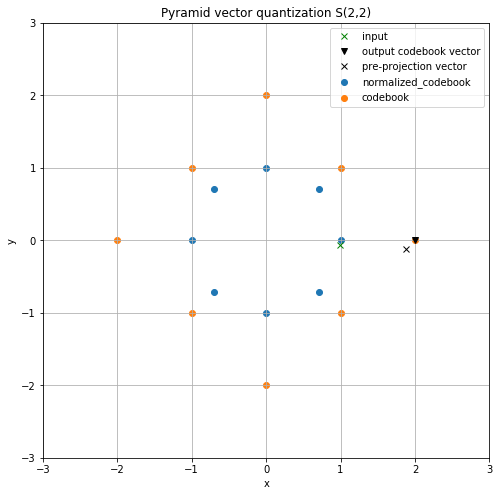

In [178]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Pyramid vector quantization S(2,2)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(( -3, 3))
ax.set_ylim((-3, 3))

line_input, = ax.plot([], [], 'gx', lw=20, label='input')
line_output, = ax.plot([], [], 'kv', lw=20, label='output codebook vector')
line_preproj, = ax.plot([], [], 'kx', lw=20, label='pre-projection vector')
ax.scatter(normalized[:,0], normalized[:,1], label='normalized_codebook')
ax.scatter(codebook[:,0], codebook[:,1], label='codebook')
ax.legend()
ax.grid()

# initialization function: plot the background of each frame
def init():
    line_input.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(t):
    pt = np.exp(2*np.pi* 0.01 * 1j * t)
    x = pt.real
    y = pt.imag
    line_input.set_data(x, y)
    act, rounded = point_on_pyramid2(np.array([x,y]), 2)
    
    line_output.set_data(rounded[0], rounded[1])
    line_preproj.set_data(act[0], act[1])

    return (line_input,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)

HTML(anim.to_html5_video())

[-1.09371591 -0.90628409] [-1. -1.]


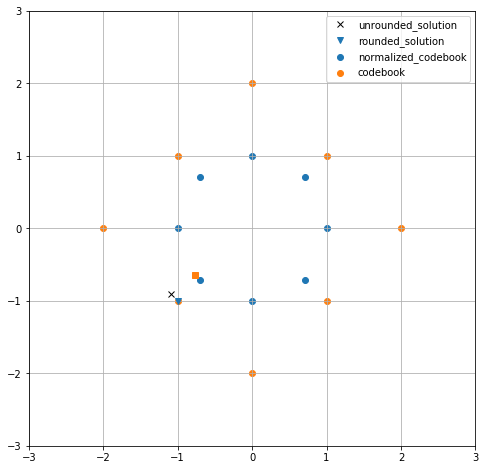

In [199]:
a = -0.77
x = np.array([a, -np.sqrt(1-a**2)])
x /= np.linalg.norm(x)
act, rounded = point_on_pyramid2(x, 2)
print(act, rounded)
plt.figure(figsize=(8,8))
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.scatter(normalized[:,0], normalized[:,1], label='normalized_codebook')
plt.scatter(codebook[:,0], codebook[:,1], label='codebook')
plt.plot([act[0]], [act[1]], 'xk', label='unrounded_solution')
plt.plot([rounded[0]], [rounded[1]], 'v', label='rounded_solution', linewidth=8)
plt.plot([x[0]], [x[1]], 's')
plt.grid()
plt.legend()

In [186]:
# Determine how to allocate bits between the gain and the shape of the vector
def fine_alloc(a, N, k_fine):
    """Given a total number of bits, calculate the number of bits for the gain-shape quantization"""
    a_shape = a/N + 0.5*np.log2(N) - k_fine
    a_shape = np.round(a_shape)
    a_gain = a - a_shape
    return a_gain, a_shape

for i in range(2, 20):
    a_g, a_f = fine_alloc(10, i, 0)
    print(f"For N={i}, bits for gain= {a_g}, bits for shape={a_f}")


For N=2, bits for gain= 4.0, bits for shape=6.0
For N=3, bits for gain= 6.0, bits for shape=4.0
For N=4, bits for gain= 6.0, bits for shape=4.0
For N=5, bits for gain= 7.0, bits for shape=3.0
For N=6, bits for gain= 7.0, bits for shape=3.0
For N=7, bits for gain= 7.0, bits for shape=3.0
For N=8, bits for gain= 7.0, bits for shape=3.0
For N=9, bits for gain= 7.0, bits for shape=3.0
For N=10, bits for gain= 7.0, bits for shape=3.0
For N=11, bits for gain= 7.0, bits for shape=3.0
For N=12, bits for gain= 7.0, bits for shape=3.0
For N=13, bits for gain= 7.0, bits for shape=3.0
For N=14, bits for gain= 7.0, bits for shape=3.0
For N=15, bits for gain= 7.0, bits for shape=3.0
For N=16, bits for gain= 7.0, bits for shape=3.0
For N=17, bits for gain= 7.0, bits for shape=3.0
For N=18, bits for gain= 7.0, bits for shape=3.0
For N=19, bits for gain= 7.0, bits for shape=3.0


In [436]:
# Number of points in the codebook
def num_points_in_pvq(L, K):
    if L >= 0 and K == 0:
        return 1
    if K >= 1 and L == 0:
        return 0
    return num_points_in_pvq(L-1, K) + num_points_in_pvq(L-1, K-1) + num_points_in_pvq(L, K-1)
    
# Encode a pyramid vq codebook vector into an integer index
def encode_pvq_vector(x, K):
    b = 0
    k = K
    L = len(x)
    l = L
 
    for x_i in x:
        if abs(x_i) == 0:
            b += 0
        if abs(x_i) == 1:
            b += num_points_in_pvq(l-1, k) + (0.5 * (1-np.sign(x_i))) * num_points_in_pvq(l-1, k-1)
        if abs(x_i) > 1:
            b += num_points_in_pvq(l-1, k) + 2*np.sum([num_points_in_pvq(l-1, k-j) for j in range(1, abs(x_i))]) + 0.5 * (1-np.sign(x_i)) * num_points_in_pvq(l-1, k-abs(x_i))
        k  -= abs(x_i)
        l -= 1
        if k == 0:
            break
    return int(b)

# Decode a pyramid vq codebook vector index into the codebook vector
def decode_pvq_vector(b, L, K):
    x = np.zeros((L, ), dtype=np.int)
    xb = 0
    k = K
    l = L
    i = 0
    while i < L:
        step_2, step_3, step_4, step_5 = True, True, True, True
        if b == xb:
            # step 1
            x[i] = 0
            step_2, step_3, step_4 = False, False, False
        # step 2            
        if step_2:
            if b < xb + num_points_in_pvq(l-1, k):            
                x[i] = 0
                step_3 = False
            else:
                xb += num_points_in_pvq(l-1, k)
                j = 1
        # step 3
        if step_3:
            while b >= xb + 2 *num_points_in_pvq(l-1,k-j):
                xb += 2 * num_points_in_pvq(l-1,k-j)
                if j < k:
                    j += 1
                else: 
                    break
            if b < xb + 2 *num_points_in_pvq(l-1,k-j):
                if xb <= b < xb+num_points_in_pvq(l-1,k-j):
                    x[i] = j
                else:
                    x[i] = -j
        # step 4
        if step_4:
            k -= abs(x[i])
            l -= 1
            i += 1
            if k > 0:
                step_5 = False
        # step 5
        if step_5:
            if k > 0:
                x[L-1] = k - abs(x[i])
            break
    return x
    
            

In [437]:
c = [-1,1]
b = encode_pvq_vector(np.array(c), 2)
print(c)
decoded = decode_pvq_vector(b, len(c), 2)
print(f'in: {c} idx: {b} decoded: {decoded}')

[-1, 1]
in: [-1, 1] idx: 4 decoded: [-1  1]


In [440]:
for c in codebook:
    b = encode_pvq_vector(np.array(c), 2)
    decoded = decode_pvq_vector(b, len(c), 2)
    print(f'in: {c} idx: {b} decoded: {decoded} success: {np.allclose(c, decoded)}')

in: [2 0] idx: 6 decoded: [2 0] success: True
in: [-2  0] idx: 7 decoded: [-2  0] success: True
in: [1 1] idx: 2 decoded: [1 1] success: True
in: [ 1 -1] idx: 3 decoded: [ 1 -1] success: True
in: [-1  1] idx: 4 decoded: [-1  1] success: True
in: [-1 -1] idx: 5 decoded: [-1 -1] success: True
in: [0 2] idx: 0 decoded: [0 2] success: True
in: [ 0 -2] idx: 1 decoded: [ 0 -2] success: True


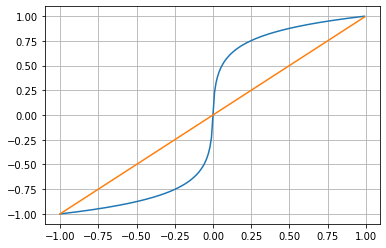

In [444]:
def mu_law_fn(x, mu=255):
    return np.sign(x) * np.log(1+mu*np.abs(x))/np.log(1+mu)

def inv_mu_law_fn(y, mu=255):
    return np.sign(y)/mu * ((1+mu)**np.abs(y) - 1)

x = np.arange(-1, 1, 0.01)
y = mu_law_fn(x)
x_hat = inv_mu_law_fn(y)
plt.plot(x, y)
plt.plot(x, x_hat)
plt.grid()

In [ ]:
# Full PVQ algorithm

def encode_decode(x, R):
    k_fine = 0
    # Allocate bits for gain and shape
    R_gain, R_shape = fine_alloc(R, len(x), k_fine):
    
    # Separate gain and shape
    gain = np.linalg.norm(x)
    shape = x / gain
    
    # Mu-law scalar quantize gain
    # TODO
    
    # Find k that satisfies R_shape
    # TODO k = 
    
    # PVQ the shape
    codebook_vector = point_on_pyramid(x, k)
    # Find index of codebook vector
    b = encode_pvq_vector(codebook_vector, k)
    
    # Transmit index
    
    # DECODER
    codebook_vector_decoded = decode_pvq_vector(b, len(x), k)
    
    # normalize to reconstruct shape
    decoded_shape = codebook_vector_decoded/np.linalg.norm(codebook_vector_decoded)
    
    # reconstruct gain
    s
        
    
